In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

In [ ]:
path_data = '../data/raw/ParisHousing.csv'
raw_data = pd.read_csv(path_data)

raw_data.head()

,Property Title,Price,Rooms,Floors,Bedrooms,Living,Type,Condition,Standing,Construction year,...,Balcony,Parking lots (outside),Parking lots (inside),Internal,Terraces,Garages (outside),Environment,Terrace,Cellar,Beds
0,PARIS 7ème - 1 chambre - view les invalides,"$1,258,458",2,4.0,1.0,50 m²,Condo/Apartment,New,High luxury,1880.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Paris 7th - 2 bedrooms - 6th floor - Balcony R...,"$1,422,604",4,6.0,2.0,68 m²,Condo/Apartment,Excellent condition,NaN,1895.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Paris 8th -Plaza Athénée Avenue Montaigne - Go...,"$2,024,475",3,NaN,2.0,70 m²,Condo/Apartment,New,High luxury,1910.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Bright Pied-à-terre on Avenue Foch,"$1,039,595",2,NaN,1.0,61 m²,Condo/Apartment,Requires renovation,Luxury,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PRIVATE ROAD - HIGH FLOOR - 4 ROOMS - BALCONY ...,"$1,805,613",4,6.0,2.0,108 m²,Condo/Apartment,Good condition,NaN,1898.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
y = raw_data.price
X = raw_data.drop(columns='price')

X_train, X_val,y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=1)

def first_test_tree(n):
    model =RandomForestRegressor(n_estimators=n,random_state=1)
    model.fit(X_train,y_train)
    preds = model.predict(X_val)
    mae = mean_absolute_error(y_val, preds)
    return mae

first_test_tree(600)

ValueError: could not convert string to float: 'House for sale in Paris, France'

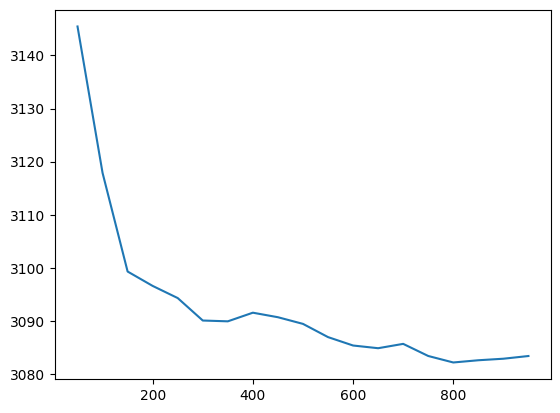

In [40]:
plt.figure()

X = [50*n for n in range(1,20)]
Y = [first_test_tree(n) for n in X]

plt.plot(X,Y)
plt.show()

Results are suspisciously low

In [41]:
imp = SimpleImputer()
model_1 = RandomForestRegressor(random_state=1, n_jobs=-1)
pipe_1 = Pipeline([
    ('preprocessor', imp),
    ('model', model_1)
])

def mae_1(X=X_train,y=y_train):
    scores = cross_val_score(pipe_1, X, y,
                             scoring='neg_mean_absolute_error',
                             cv=10)
    return -1*scores.mean()

mae_1() 


np.float64(3164.9457088749705)

Scores are surprisingly very low, there may be a data leakage we need to adress

In [48]:
#X.columns
#no data leakage in sight
#lets test with a dummy
model_dum = DummyRegressor(strategy='mean')
model_dum.fit(X_train, y_train)
mae = mean_absolute_error(model_dum.predict(X_val),y_val)
print(mae)

#y.describe()

for col in X.columns:
    corr = np.corrcoef(X[col], y)[0, 1]
    print(f"{col}: correlation with y = {corr:.4f}")


2433946.5727093997
squareMeters: correlation with y = 1.0000
numberOfRooms: correlation with y = 0.0096
hasYard: correlation with y = -0.0061
hasPool: correlation with y = -0.0051
floors: correlation with y = 0.0017
cityCode: correlation with y = -0.0015
cityPartRange: correlation with y = 0.0088
numPrevOwners: correlation with y = 0.0166
made: correlation with y = -0.0072
isNewBuilt: correlation with y = -0.0106
hasStormProtector: correlation with y = 0.0075
basement: correlation with y = -0.0040
attic: correlation with y = -0.0006
garage: correlation with y = -0.0172
hasStorageRoom: correlation with y = -0.0035
hasGuestRoom: correlation with y = -0.0006


found the data leakage, I think it's because prices in Paris are limited by the squaremeters or something like that

In [49]:
new_X = X.drop(columns='squareMeters')
X_train, X_val, y_train, y_val = train_test_split(new_X, y)
pipe_1.fit(X_train, y_train)
preds = pipe_1.predict(X_val)
print(mean_absolute_error(y_val, preds))

2536621.890996


As predicted, we get way worse results droping the square meters column, so its a near perfect correlation with the price, lets try with just the surface and nothing else

In [50]:
new_X = X[['squareMeters','isNewBuilt']]
X_train, X_val, y_train, y_val = train_test_split(new_X, y)
pipe_1.fit(X_train, y_train)
preds = pipe_1.predict(X_val)
print(mean_absolute_error(y_val, preds))

3199.521522513815


changed the dataset because it was too clean, found another one, seems to have the same problem, found another one with messier data, let's start cleaning it and see what we get

In [127]:
X.head()

,Rooms,Floors,Bedrooms,Living,Type,Condition,Standing,Construction year,Renovation year,Heating,...,Balcony,Parking lots (outside),Parking lots (inside),Internal,Terraces,Garages (outside),Environment,Terrace,Cellar,Beds
0,2,4.0,1.0,50.0,Condo/Apartment,New,High luxury,1880.0,2023.0,"Central, Gas",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4,6.0,2.0,68.0,Condo/Apartment,Excellent condition,NaN,1895.0,2020.0,"Central, Common, Gas",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,2.0,70.0,Condo/Apartment,New,High luxury,1910.0,2024.0,"Central, Gas",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,NaN,1.0,61.0,Condo/Apartment,Requires renovation,Luxury,NaN,NaN,"Radiator, Common, Gas",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,6.0,2.0,108.0,Condo/Apartment,Good condition,NaN,1898.0,NaN,"Radiator, Common, Gas",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
path = '../data/raw/houses.csv'
X = pd.read_csv(path)
y = X.Price
#We do a little cleaning of the data
X = X.drop(columns=['Price','Property Title','Cellar','Beds','Terrace']) #we drop property title because it gives no useful information and others have only NaNs
X['Living'] = X['Living'].str.replace(' m²', '', regex=False).astype(float) #we take off the m² so we don't have to deal with it
y = y.str.replace('[^\d.]', '', regex=True) #we take off the '$'s and ','s from the price so we have clean integers


X_train, X_val, y_train, y_val = train_test_split(X,y) #we split the data for training and validation

enc = OneHotEncoder(handle_unknown='ignore')
#we find categorical and numerical columns 
cols = [col for col in X.columns]
cat_cols = [col for col in cols if X[col].dtype == 'object']
#print(cat_cols)
num_cols = [col for col in cols if col not in cat_cols]
#print(num_cols)

num_transformer = SimpleImputer(strategy='mean')
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', enc)
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

pipe = Pipeline([
    ('preprocess',preprocessor),
    ('model',XGBRegressor(n_estimators=500, learning_rate=0.05, n_jobs=-1))
])

pipe.fit(X_train,y_train)


<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
C:\Users\PC\AppData\Local\Temp\ipykernel_17920\476539270.py:7: SyntaxWarning: invalid escape sequence '\d'
  y = y.str.replace('[^\d.]', '', regex=True) #we take off the '$'s and ','s from the price so we have clean integers


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['Rooms', 'Floors',
                                                   'Bedrooms', 'Living',
                                                   'Construction year',
                                                   'Renovation year',
                                                   'Bathrooms', 'Toilet rooms',
                                                   'Shower rooms', 'Balconies',
                                                   'Parking lots (outside)',
                                                   'Parking lots (inside)',
                                                   'Terraces',
                                                   'Garages (outside)']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=500, n_jobs=-1,
                              num_parallel_tree=None, ...))])

In [131]:

score = cross_val_score(pipe, X_train, y_train,
                        cv=5,
                        scoring='neg_mean_absolute_error')
print(f"model score : {-1*score.mean()}") #first results

score_dum = cross_val_score(model_dum, X_train, y_train,
                            cv=5,
                            scoring='neg_mean_absolute_error')
print(f"dummy score : {-1*score_dum.mean()}")

model score : 155806.2171875
dummy score : 461894.1117427434


now we have interesting results, the model is giving good predictions without it being unrealistic !

In [133]:
X.to_csv('../data/processed/X.csv')
y.to_csv('../data/processed/y.csv')